# Posterior Predictive Check

Import necessary modules:

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import gamma
import preliz as pz
from tqdm.auto import tqdm
import matplotlib as mpl
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,3)

Data (maternity ward example):

In [3]:
y = np.array([ 7,  8,  3,  7, 11,  7,  9, 19,  7, 15,  9,  5, 12,  3,  7,  6,  5, 3, 11,  5])

## Poisson Model

Prior from exercise:

<Axes: >

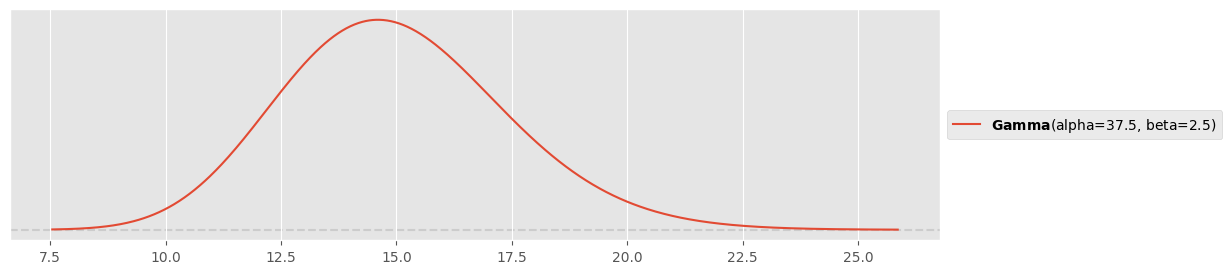

In [4]:
pz.Gamma(37.5, 2.5).plot_pdf()

Simulate posterior:

In [5]:
with pm.Model() as maternity_ward_model:
    lbd = pm.Gamma( 'lbd', alpha=37.5, beta=2.5 )
    y_obs = pm.Poisson( 'y_obs', mu=lbd, observed=y )
    trace = pm.sample( 1000 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lbd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Posterior distribution for $\lambda$:

<Axes: title={'center': 'lbd'}>

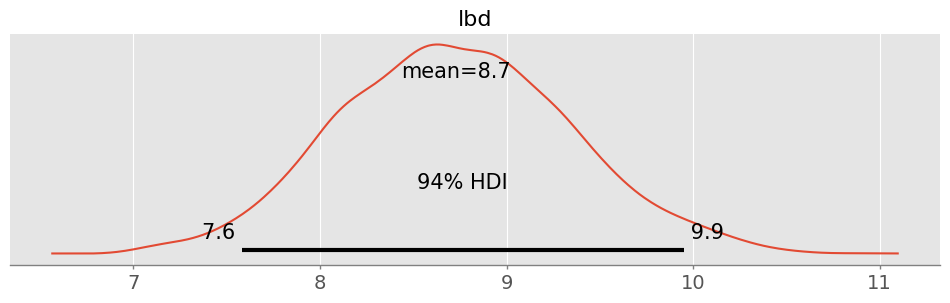

In [6]:
pm.plot_posterior( trace )

Predictive Test:

In [7]:
with maternity_ward_model:
    ppc = pm.sample_posterior_predictive(trace)

Sampling: [y_obs]


Output()

Visualize using a density plot (instead of histogram used by `pm.plot_ppc()`):

(0.0, 30.0)

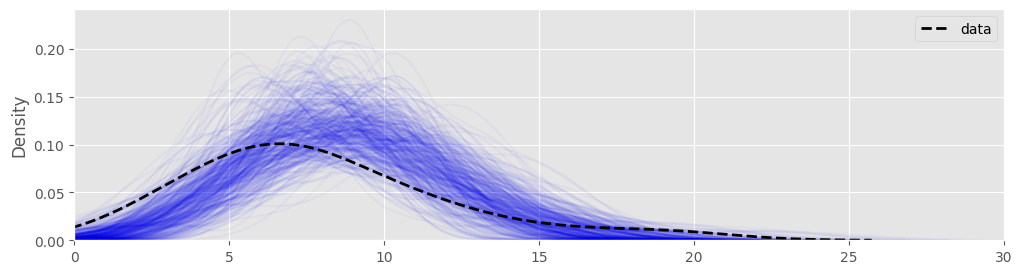

In [8]:
def ppc_plot( ppc, num_pp_samples=100 ):
    preds = ppc.posterior_predictive.y_obs.values.reshape(-1,20)
    samples = np.random.randint( preds.shape[0], size=num_pp_samples )
    
    for i in range(num_pp_samples):
        sns.kdeplot( preds[samples[i],:], c="blue", alpha=0.03 )
    sns.kdeplot( ppc.observed_data.y_obs, c="black", ls="--", lw=2, label="data" )
    plt.legend()
    plt.xlim(0, np.max(preds[samples,:]))

ppc_plot( ppc, num_pp_samples=500 )
plt.xlim(0, 30)

Clearly the predictive distribution has a different mode than the data distribution!

With PyMC (harder to interpret in this case):

<Axes: xlabel='y_obs'>

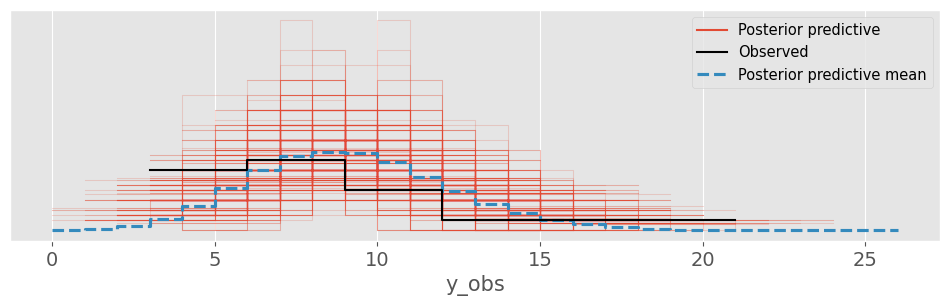

In [9]:
az.plot_ppc(ppc, num_pp_samples=500 )

Checking the assumptions of the Poisson distribution: ($E[Y] = \text{Var}[Y] = \lambda$)

In [10]:
np.mean( y )

7.95

In [11]:
np.var( y )

15.8475

Clearly quite different!

## Negative Binomial Model

Prior for $\alpha$ (or $r$ as used in the lecture notes):

<Axes: >

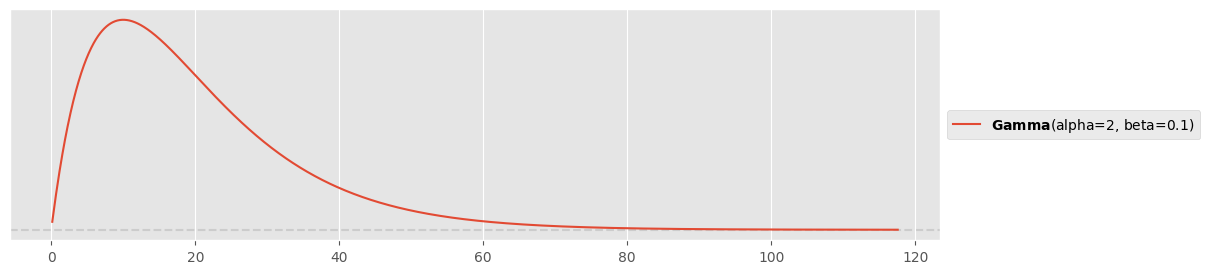

In [12]:
pz.Gamma(alpha=2, beta=0.1).plot_pdf()

PyMC model:

In [13]:
with pm.Model() as maternity_ward_model2:
    lbd = pm.Gamma( 'lbd', alpha=37.5, beta=2.5 )
    alpha = pm.Gamma( 'alpha', alpha=2, beta=0.1 )
    y_obs = pm.NegativeBinomial( 'y_obs', mu=lbd, alpha=alpha, observed=y )
    trace2 = pm.sample( 1000 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lbd, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Posterior distributions:

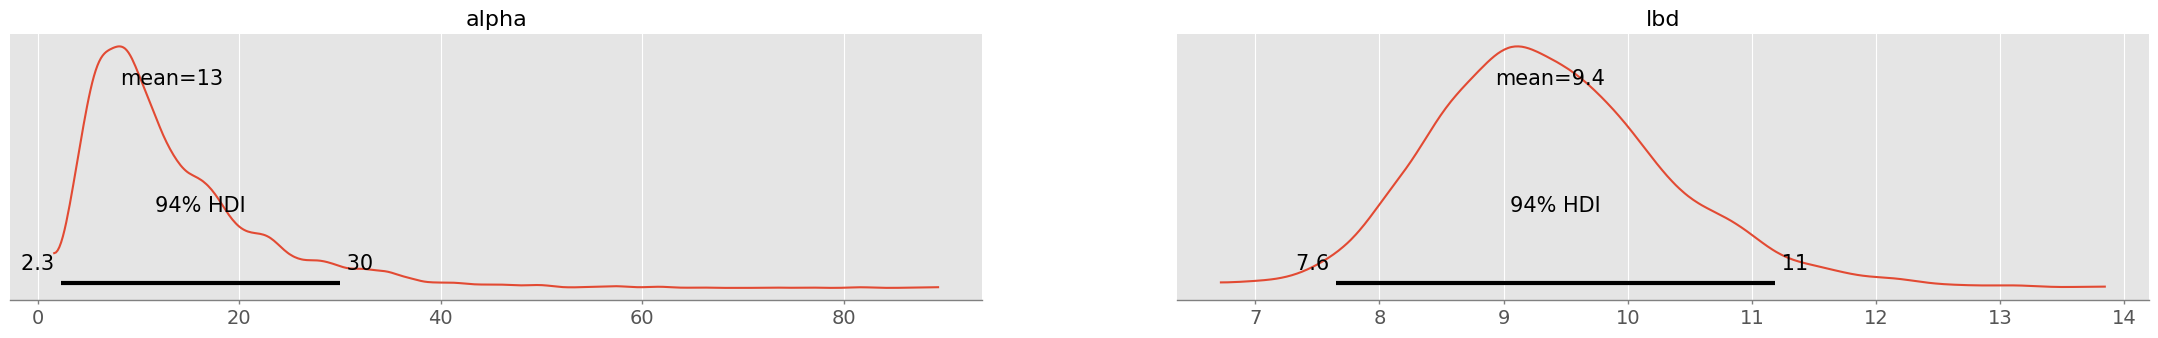

In [14]:
pm.plot_posterior( trace2 );

More uncertainty in $\lambda$! And additional uncertainty in $\alpha$ that is still quite large.

Posterior predictive check:

In [15]:
with maternity_ward_model2:
    ppc2 = pm.sample_posterior_predictive(trace2)

Sampling: [y_obs]


Output()

(0.0, 0.25)

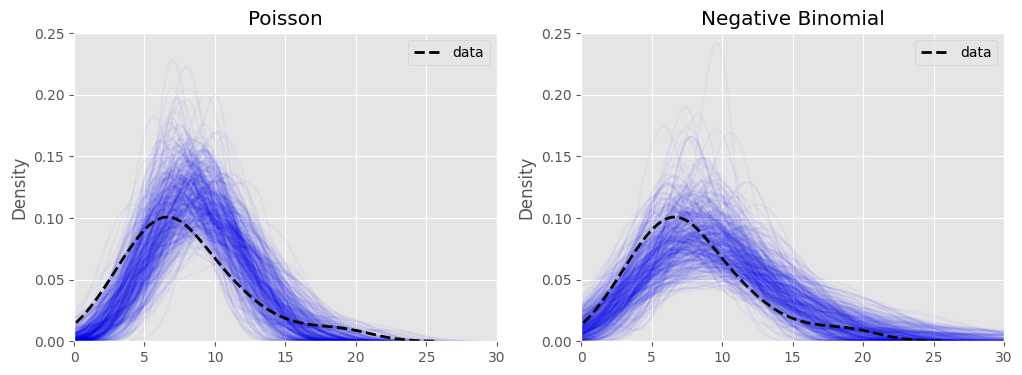

In [16]:
fig, ax = plt.subplots( 1, 2, figsize=(12,4) )
plt.sca( ax[0] )
ppc_plot( ppc, num_pp_samples=500 )
plt.title("Poisson")
plt.xlim(0, 30)
plt.ylim(0, 0.25)
plt.sca( ax[1] )
ppc_plot( ppc2, num_pp_samples=500 )
plt.title("Negative Binomial")
plt.xlim(0, 30)
plt.ylim(0, 0.25)

Predictions of the negative binomial distribution match the data a bit better!

With PyMC (harder to interpret):

(0.0, 0.35)

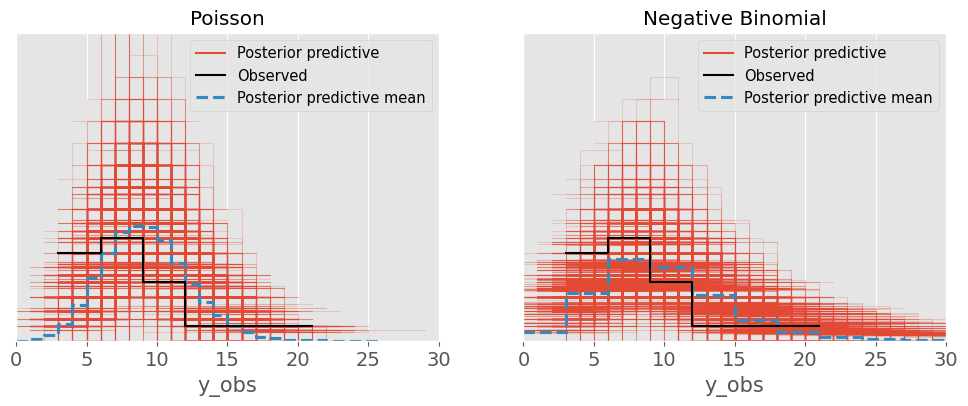

In [17]:
fig, ax = plt.subplots( 1, 2, figsize=(12,4) )
plt.sca( ax[0] )
pm.plot_ppc( ppc, ax=ax[0] )
plt.title("Poisson")
plt.xlim(0, 30)
plt.ylim(0, 0.35)
plt.sca( ax[1] )
pm.plot_ppc( ppc2, ax=ax[1] )
plt.title("Negative Binomial")
plt.xlim(0, 30)
plt.ylim(0, 0.35)